# Warfish Dice-3: At Least Graphs
What happens when we fight a battle all the way through to the end? What is the probability of succeding? How many troops will we have left at the end? These questions are answered by At Least Graph

Below we employ Monte Carlo simulation to navigate intricate dynamics of battle on the Warfish gameboard. 

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.image as mpimg

In [2]:
rng = np.random.default_rng()

# this rolls one n_dice with n_sides once each. 
def roll_dice(n_sides, n_dice):
    return (rng.integers(low = 1, high = n_sides, size = n_dice, endpoint=True)).tolist()


# Let's reform the roll and attack functions so that they are markov chaning
def attack_m(n_a_troops, n_d_troops, n_a_dice=3, n_a_sides=6, n_d_sides=6, debug=False):
    # m stands for matrix output
    # n_a_troops is the number of troops on the board in attackers position
    # n_d_troops is the number of troops on the board in the defenders position
    # n_a_dice is the number of attack dice desired to be rolled each time
    # n_a_sides is number of sides on the attack dice (usually 6)
    # n_d_sides is numer of sides on the defend dice (usually 6)
    
    # number of defending dice. always assumed to be 2 unless less troops available
    ndd = 2
    
    score = np.zeros((n_a_troops, n_d_troops+1), dtype=int)
    
    # no troops left to attack or defend with
    # this while condition assumes we're fighting to the death
    while (n_a_troops > 1 and n_d_troops > 0):
        # attack!
        # n_a_sides is n_a_sides unless less troops available. fight to the death!
        nad = n_a_troops-1 if n_a_troops -1 < n_a_dice else n_a_dice
        ndd = n_d_troops if n_d_troops < ndd else ndd
        
        min_die = min([nad, ndd])
        
        a_rolls = roll_dice(n_a_sides, nad)
        d_rolls = roll_dice(n_d_sides, ndd)
        
        a_rolls.sort(reverse=True)
        d_rolls.sort(reverse=True)
        
        if debug:
            print("a rolls: ", a_rolls)
            print("d rolls: ", d_rolls)
        for i in range(min_die):
            if a_rolls[i] > d_rolls[i]:
                n_d_troops -=1
            else:
                n_a_troops -=1
        
        score[n_a_troops-1][n_d_troops] +=1
        if debug:
            print(score)
    
    return score

def attack_stats_m(n_a_troops, n_d_troops, n_a_dice=3, n_iter=10000, n_a_sides=6, n_d_sides=6):
    results = np.zeros((n_a_troops, n_d_troops+1), dtype=int)
    for i in range(n_iter):
        end_state = attack_m(n_a_troops, n_d_troops, n_a_dice, n_a_sides, n_d_sides)
        results += end_state
    
    return results

def result_from_matrix(score_matrix):
    defenders_left = score_matrix[0][1:].tolist()
    defenders_left.reverse()
    attackers_left = []
    for i in range(1, len(score_matrix)):
        attackers_left.append(score_matrix[i][0])

    result = defenders_left + attackers_left
    return result, len(defenders_left)

def plot_single_at_least(score, picture=None):
    result, pivot = result_from_matrix(score)
    result.reverse()

    sum_array = [result[0]]
    for i in range(1,len(result)):
        sum_array.append(sum_array[-1] + result[i])

    result = [ i / max(sum_array) for i in sum_array]
    result.reverse()

    n_attackers = len(result)-pivot+1

    x_ticks = np.arange(-pivot, 0).tolist() + np.arange(2,n_attackers+1).tolist()
    x_ticks_s = [str(i) for i in x_ticks]
    
    ## plot stuff
    if picture == None:
        fig, ax = plt.subplots()
    else:
        fig, axs = plt.subplots(1,2, figsize=(10,5))
        arr_pic = mpimg.imread('img/'+picture)
        axs[0].imshow(arr_pic)
        axs[0].set_xticks([])
        axs[0].set_yticks([])
        ax = axs[1]
        
    ax.plot(range(len(result)), result, label="5v5", marker='s')
    ax.set_xticks(range(len(result)))
    ax.set_xticklabels(x_ticks_s)
    ax.yaxis.set_major_formatter(mticker.PercentFormatter(1,decimals=0))
    ax.set_yticks(np.arange(0,1,.05), minor=True)
    ax.grid(which='both')
    ax.grid(which='minor', alpha=0.5, linestyle=':')
    ax.axhline(y=result[pivot])
    loss = "loss: {:.1f}%".format(100*(1-result[pivot]))
    win  = "win:  {:.1f}%".format(100*result[pivot])
    ax.text(0, result[pivot]+.03, loss, color = "red")
    ax.text(0, result[pivot]-.05, win, color = "green")

    plt.show()

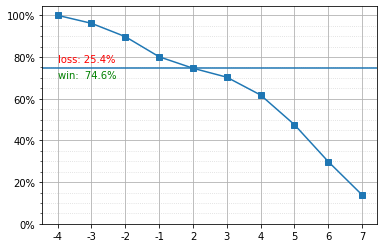

In [3]:
plot_single_at_least(attack_stats_m(7,4))

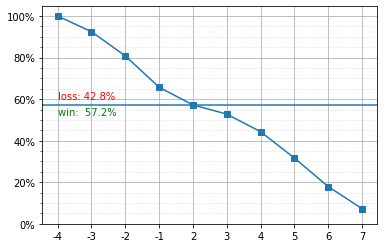

In [4]:
plot_single_at_least(attack_stats_m(7,4, n_d_sides=7))

## Let's try a few examples
Remember these are all "fight to the death" scenarios

### 3 vs 1, defender with 7 sides

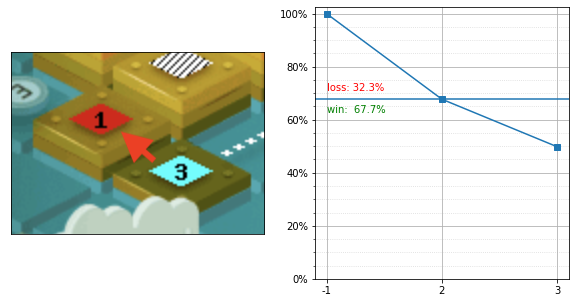

In [5]:
plot_single_at_least(attack_stats_m(3,1, n_d_sides=7), picture = '3v1.png')

We can read the preceding graph as follows: 

There is at least 100% chance that the outcome will be ( the attacker loses both attacking troops and the defender is left standing with 1 troop) or better. :: **Failure** ::

There is at least a 67% chance that ( the defender will lose one troop and attacker will lose one troop ) or better. :: **Success** ::

There is at least a 48% chance that ( the defender will lose both troops, the attacker takes no losses). :: **Success** ::

All combined, if taking a territory is your goal, you have a 67% chance of success

### 4 vs 6, defender with 7 sides

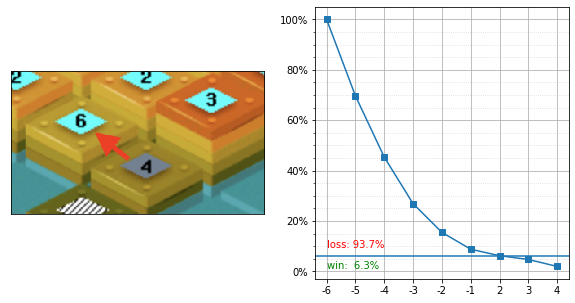

In [6]:
plot_single_at_least(attack_stats_m(4,6, n_d_sides=7), picture = '4v6.png')

Atacking in this configuration has a combined probability of success of 6.2%. This is basically a "Hail Mary" attack.

### 4 vs 3, defender with 9 sides

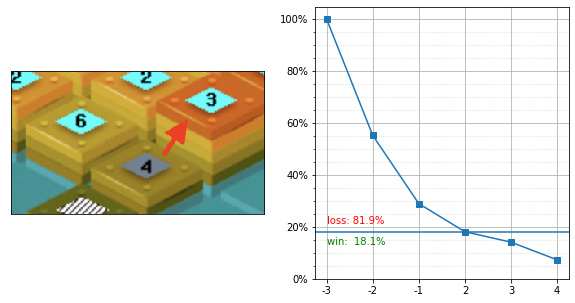

In [7]:
plot_single_at_least(attack_stats_m(4,3, n_d_sides=9), picture = '4v3.png')

Combined probability of success here is 18.9%. Still low, but 3x more chance of success than the previous example of blue attacking 6, even though in this configuration the defender is rolling 9-sided dice.

### 5 vs 3, defender with 7 sides

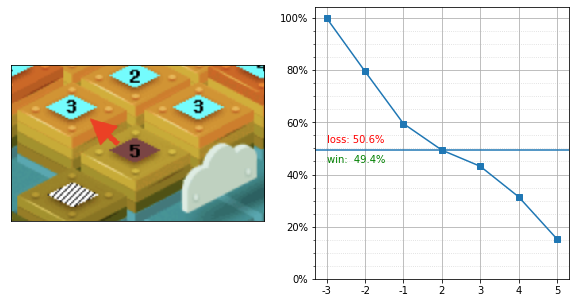

In [8]:
plot_single_at_least(attack_stats_m(5,3, n_d_sides=7), picture = '5v3.png')

There's almost a 50% chance of success here which seems good, although winning will leave you defenseless, with only 1 troop guarding each square. Winning a "major" victory and having enough troops left to defend both tiles effectively (having 4 troops left over or 2 to guard each tile) has a 31% chance.